In [ ]:
import pandas as pd
import spacy
import nltk
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
import gensim.downloader as api
from gensim.models import Word2Vec
import tensorflow as tf
import numpy as np

In [ ]:
# Loading already pre-processed dataset from its pickle file. This pickle file was created during running LSTM models
df = pd.read_pickle("./processed_dataset.pkl")

In [ ]:
df

,text,polarity,sentiment,tokenized_text,tokenized_text_2
0,god be praised a from drcongo,0.000000,neutral,"[god, be, praised, a, from, drcongo]",god praised drcongo
1,fantastic performance good to see richard,0.550000,positive,"[fantastic, performance, good, to, see, richard]",fantastic performance good see richard
2,greetings from kosovo south east europe,0.000000,neutral,"[greetings, from, kosovo, south, east, europe]",greetings kosovo south east europe
3,it is monday evening in sydney australia when ...,0.387500,positive,"[it, is, monday, evening, in, sydney, australi...",monday evening sydney australia tune week appr...
4,watching this at the end of the day was so upl...,0.475000,positive,"[watching, this, at, the, end, of, the, day, w...",watching end day uplifting comforting song cho...
...,...,...,...,...,...
56776,szelenskyy snow sorting criminal that is a fact,-0.400000,negative,"[szelenskyy, snow, sorting, criminal, that, is...",szelenskyy snow sorting criminal fact
56777,congratulations now europe becomes chessboard ...,0.500000,positive,"[congratulations, now, europe, becomes, chessb...",congratulations europe becomes chessboard supe...
56778,if the west would deliver more weapons atm the...,0.178571,positive,"[if, the, west, would, deliver, more, weapons,...",west would deliver weapons atm seems enough st...
56779,ukrainian people are showing the whole world w...,0.260000,positive,"[ukrainian, people, are, showing, the, whole, ...",ukrainian people showing whole world fighting ...


In [ ]:
sentences = df['tokenized_text_2']
sentences = [str(s) for s in sentences]


In [ ]:
def normalizeRangeR(val):
  oldMin = -1.0
  oldMax = 1.0
  newMin =0.0
  newMax = 1.0
  oldRange  = oldMax - oldMin
  newRange = newMax - newMin
  polarity = (((val - oldMin) * newRange) / oldRange) + newMin
  return polarity

def normalizeRangeC(val):
  if val>=0:
    return int(1)
  else:
    return int(0)

# Perform additional steps in data preparation for classification and regression tasks

# Converting labels to 1 or 0 for classification tasks    
df['polarity_c']=df['polarity'].apply(lambda x: normalizeRangeC(x))

# Scaling labels in the range  0 to 1 for regression tasks
df['polarity_r']=df['polarity'].apply(lambda x: normalizeRangeR(x))

In [ ]:
preTrainedModelPath = '../root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz'
word_vectors = KeyedVectors.load_word2vec_format(preTrainedModelPath, binary=True)

In [ ]:
labelsC = df['polarity_c']
labelsR = df['polarity_r']

In [ ]:
labelsR

0        0.500000
1        0.775000
2        0.500000
3        0.693750
4        0.737500
           ...   
56776    0.300000
56777    0.750000
56778    0.589286
56779    0.630000
56780    0.500000
Name: polarity_r, Length: 56781, dtype: float64

In [ ]:
# CREATING TRAIN TEST SPLIT
from sklearn.model_selection import train_test_split
x_trainC, x_testC, y_trainC, y_testC = train_test_split(sentences, labelsC, test_size = 0.3, train_size=0.7, random_state=1)

x_trainR, x_testR, y_trainR, y_testR = train_test_split(sentences, labelsR, test_size = 0.3, train_size=0.7, random_state=1)

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(x_trainC)
vocab_size = len(tokenizer.word_counts) + 2

In [ ]:
print(vocab_size)

38688


In [ ]:
word2idx= tokenizer.word_index
idx2word = {k:v for (v,k) in word2idx.items()}

In [ ]:
seqLengths = np.array([len( s.split() ) for s in x_trainC] )
print( [ (p, np.percentile(seqLengths, p)) for p in [75,80,90,95,99,100]])

[(75, 14.0), (80, 17.0), (90, 28.0), (95, 44.0), (99, 123.0), (100, 1030.0)]


In [ ]:
maxSeqLen = 125

In [ ]:
x_train_as_ints = tokenizer.texts_to_sequences(x_trainC)
x_train_as_ints = tf.keras.preprocessing.sequence.pad_sequences(x_train_as_ints, maxlen=maxSeqLen)

y_train_as_ints_C = np.array(y_trainC)
y_train_as_ints_R = np.array(y_trainR)

In [ ]:
x_test_as_ints = tokenizer.texts_to_sequences(x_testC)
x_test_as_ints = tf.keras.preprocessing.sequence.pad_sequences(x_test_as_ints, maxlen=maxSeqLen)

y_test_as_ints_C = np.array(y_testC)
y_test_as_ints_R = np.array(y_testR)

In [ ]:
# Creating and embedding matrix for our vocabulary

embedding_dim = 300
hits = 0
misses =0

embeddingMatrix = np.zeros((vocab_size,embedding_dim))
for word, i in tokenizer.word_index.items():
  if word in word_vectors:
    embeddingVector = word_vectors[word]
    embeddingMatrix[i] = embeddingVector
    hits+=1
  else:
    misses+=1

In [ ]:
print("Converted words: %d (no. of misses: %d)" % (hits, misses))

Converted words: 27728 (no. of misses: 10959)


In [ ]:
# Defining the classification model

modelC = tf.keras.models.Sequential()
modelC.add(tf.keras.layers.Embedding(
    vocab_size, 
    300,
    input_length=maxSeqLen,
    embeddings_initializer=tf.keras.initializers.Constant(embeddingMatrix),
    trainable=False) )
modelC.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
modelC.add(tf.keras.layers.MaxPooling1D(pool_size=2))
modelC.add(tf.keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu'))
modelC.add(tf.keras.layers.MaxPooling1D(pool_size=2))
modelC.add(tf.keras.layers.Flatten())
modelC.add(tf.keras.layers.Dense(10, activation='relu'))
modelC.add(tf.keras.layers.Dense(1, activation='sigmoid'))
print(modelC.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 125, 300)          11606400  
                                                                 
 conv1d_8 (Conv1D)           (None, 118, 32)           76832     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 59, 32)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 52, 64)            16448     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 26, 64)           0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 1664)             

In [ ]:
# Defining the regression model

modelR = tf.keras.models.Sequential()
modelR.add(tf.keras.layers.Embedding(
    vocab_size, 
    300,
    input_length=maxSeqLen,
    embeddings_initializer=tf.keras.initializers.Constant(embeddingMatrix),
    trainable=False) )
modelR.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
modelR.add(tf.keras.layers.MaxPooling1D(pool_size=2))
modelR.add(tf.keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu'))
modelR.add(tf.keras.layers.MaxPooling1D(pool_size=2))
modelR.add(tf.keras.layers.Flatten())
modelR.add(tf.keras.layers.Dense(10, activation='relu'))
modelR.add(tf.keras.layers.Dense(1))
print(modelR.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 125, 300)          11606400  
                                                                 
 conv1d_10 (Conv1D)          (None, 118, 32)           76832     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 59, 32)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 52, 64)            16448     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 26, 64)           0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 1664)             

In [ ]:
data_dir = '../root/dataC'
logs_dir = '../root/logsC'

best_model_file_C = '../root/dataC/best_model_CNN_C.h5'
best_model_file_R = '../root/dataC/best_model_CNN_R.h5'

checkpointC = tf.keras.callbacks.ModelCheckpoint(best_model_file_C,save_best_only=True,save_weights_only=True)
checkpointR = tf.keras.callbacks.ModelCheckpoint(best_model_file_R,save_best_only=True,save_weights_only=True)

tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

In [ ]:
modelC.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
modelR.compile(loss='mse',optimizer='adam',metrics=['mse'])

In [ ]:
historyC = modelC.fit(x_train_as_ints, y_train_as_ints_C, epochs=10,validation_split=0.2,batch_size =64,callbacks=[checkpointC, tensorboard])

Epoch 1/10
497/497 [==============================] - 13s 25ms/step - loss: 0.4563 - accuracy: 0.7984 - val_loss: 0.3909 - val_accuracy: 0.8301
Epoch 2/10
497/497 [==============================] - 12s 23ms/step - loss: 0.3410 - accuracy: 0.8546 - val_loss: 0.3302 - val_accuracy: 0.8626
Epoch 3/10
497/497 [==============================] - 12s 23ms/step - loss: 0.2507 - accuracy: 0.9000 - val_loss: 0.3258 - val_accuracy: 0.8642
Epoch 4/10
497/497 [==============================] - 12s 23ms/step - loss: 0.1598 - accuracy: 0.9433 - val_loss: 0.3576 - val_accuracy: 0.8755
Epoch 5/10
497/497 [==============================] - 12s 25ms/step - loss: 0.0901 - accuracy: 0.9715 - val_loss: 0.4348 - val_accuracy: 0.8691
Epoch 6/10
497/497 [==============================] - 11s 23ms/step - loss: 0.0557 - accuracy: 0.9852 - val_loss: 0.5237 - val_accuracy: 0.8631
Epoch 7/10
497/497 [==============================] - 15s 30ms/step - loss: 0.0390 - accuracy: 0.9893 - val_loss: 0.6056 - val_accuracy:

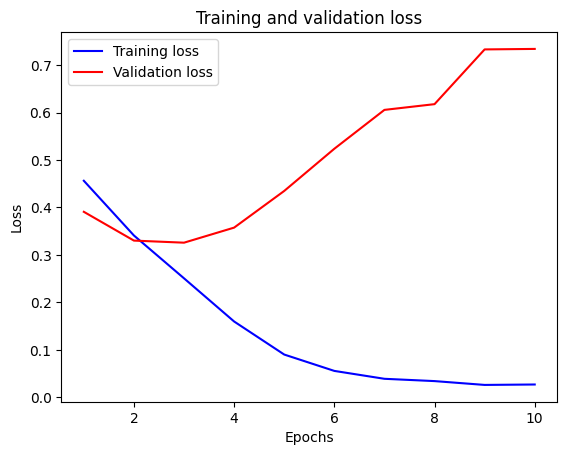

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Plot the training and validation loss vs epoch
train_loss = historyC.history['loss']
val_loss = historyC.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
modelC.load_weights(best_model_file_C)
modelC.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
modelC.evaluate(x_test_as_ints,y_test_as_ints_C)

533/533 [==============================] - 2s 4ms/step - loss: 0.3271 - accuracy: 0.8637


[0.327146977186203, 0.8636924028396606]

In [ ]:
nlp = spacy.load('en_core_web_sm')

def tokenize(inputStr):
  doc = nlp(inputStr)
  # print(type(doc))
  tokens = [str(token) for token in doc]
  # print(type(tokens))
  return tokens

stopWords = set(stopwords.words('english'))
# print(stopWords)
def removeStopWords(tokenizedSentence):
  filteredSent = []
  wordsIgnored = 0
  for token in tokenizedSentence:
    if token in stopWords:
      wordsIgnored+=1
      continue
    filteredSent.append(token)
  # print("Words ignored=",wordsIgnored)
  outputStr = " ".join(filteredSent)
  return outputStr

In [ ]:
testSentences = ["this is a bad product", 'amazing music', "horrible attitude of this politician", "This is shambolic"]

cleanedSentences = []
for sen in testSentences:
  cleanedSent  = removeStopWords(tokenize(sen))
  cleanedSentences.append(cleanedSent)

testSentences = np.array(cleanedSentences)

x_as_ints = tokenizer.texts_to_sequences(testSentences)
x_as_ints = tf.keras.preprocessing.sequence.pad_sequences(x_as_ints, maxlen=maxSeqLen)

x = modelC.predict(x_as_ints)

1/1 [==============================] - 0s 24ms/step


In [ ]:
for prob in x:
  if prob >= 0.5:
    print("Positive")
  else:
    print("Negative")

[0.00375607]
[0.99974316]
[0.00089391]
[0.8788685]


In [ ]:
print(y_train_as_ints_R)
historyR = modelR.fit(x_train_as_ints, y_train_as_ints_R, epochs=10,validation_split=0.2,batch_size =64,callbacks=[checkpointR, tensorboard])

[1.         0.7875     0.2        ... 0.65916667 0.6        0.54375   ]
Epoch 1/10
497/497 [==============================] - 13s 25ms/step - loss: 0.0181 - mse: 0.0181 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 2/10
497/497 [==============================] - 12s 23ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 3/10
497/497 [==============================] - 12s 23ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 4/10
497/497 [==============================] - 11s 23ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 5/10
497/497 [==============================] - 11s 23ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 6/10
497/497 [==============================] - 11s 23ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 7/10
497/497 [==============================] - 11s 23ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0082 - val_ms

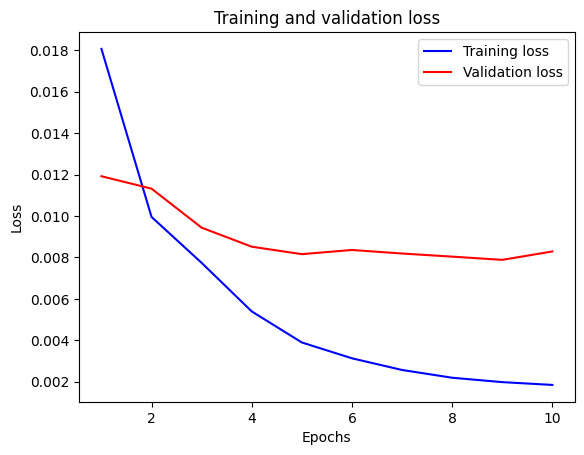

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Plot the training and validation loss vs epoch
train_loss = historyR.history['loss']
val_loss = historyR.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
modelR.load_weights(best_model_file_R)
modelR.compile(loss='mse',optimizer='adam',metrics=['mse'])
modelR.evaluate(x_test_as_ints,y_test_as_ints_R)

533/533 [==============================] - 3s 6ms/step - loss: 0.0081 - mse: 0.0081


[0.008117620833218098, 0.008117620833218098]

In [ ]:
testSentences = ["this is a bad product", 'amazing music', "horrible attitude of this politician", "This is shambolic"]

cleanedSentences = []
for sen in testSentences:
  cleanedSent  = removeStopWords(tokenize(sen))
  cleanedSentences.append(cleanedSent)

testSentences = np.array(cleanedSentences)

x_as_ints = tokenizer.texts_to_sequences(testSentences)
x_as_ints = tf.keras.preprocessing.sequence.pad_sequences(x_as_ints, maxlen=maxSeqLen)

x = modelR.predict(x_as_ints)

1/1 [==============================] - 0s 94ms/step


In [ ]:
print("Polarities")
for pol in x:
  print(pol)

Polarities
[0.10222226]
[0.8041912]
[0.06022811]
[0.49284095]
